# Linear Regression Algorithm Comparison

## Introduction

In this project I am comparing the results of using the Linear Regression algorithm I built from scratch to  SKLearn's Linear Regression Algorithm. 

Overview:
- Data will be prepared before fitting models
- Both models will be trained on the same data set
- Results will be displayed and discussed
- Hyperparameter tuning will also be discussed

Expectations:  
 - Obviously, SKLearn's Linear Regression algorithm has been optimized by many professionals. I don't expect mine to outperform it. However, if my algorithm can achieve accuracy levels comparable to those of SKLearn's, I would consider it a win. 

 - Note that I built my LinearRegression class intentionally avoided libraries like NumPy in order to gain a deeper understanding of the underlying math. This certainly resulted in less efficient code. I am not overly concerned about the time it takes to run, even though I am tracking it. 

 - The primary goal was to learn from the process and gain insights into the inner workings of the Linear Regression algorithm. This comparison project is for fun and is not meant to show off a superior product.



## Imports:

In [1]:
import numpy as np

import pandas as pd
pd.set_option('display.max_columns', 100)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

from matplotlib import pyplot as plt
%matplotlib inline 

import seaborn as sns
sns.set_style('darkgrid')

from sklearn.linear_model import LinearRegression as SKLinearRegression

from sklearn.model_selection import train_test_split

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

#Import my own Linear Regression Class
import sys
sys.path.append(r'C:\Users\The Lappy\Desktop\ML PROJECTS MAIN DIRECTORY\Linear Regression from Scratch')
from Linear_Regression_Class import LinearRegression as ScratchLinearRegression

#So we can compare efficiency
import time

import pickle

## Re-Preprocess Data

#### Explanation:  
This ABT I loaded here is from my *House Prices - Advanced Regression Techniques* project. It has already been cleaned and preprocessed. Unlike this project, that one used regularized models which essentially perform automatic feature selection. 

This means, we should revisit the dataset and preprocess it again. We need to examine the **correlation** between features and the target variable (SalePrice), and remove features with weak correlations.

We also need to check for **multicollinearity** and remove highly correlated features if necessary.


In [2]:
#Read the ABT from the previous project
df = pd.read_csv('analytical_base_table.csv')
print(df.shape)

(1451, 182)


#### Remove Features w/ weak correlations
Here I am removing input variables that are not strongly correlated with the Target Variable. Here I set the correlation threshold at 0.6.

In [3]:

# Calculate the correlation matrix
correlation_matrix = df.corr()

# Get the absolute correlation values for the target variable (e.g., 'SalePrice')
abs_target_corr = correlation_matrix['SalePrice'].abs()

# Set the correlation threshold
threshold = 0.6

# Identify the features to keep based on the correlation threshold
features_to_keep = abs_target_corr[abs_target_corr >= threshold].index.tolist()

# Remove the target variable from the list of features to keep
features_to_keep.remove('SalePrice')

# Create a new DataFrame with the selected features
filtered_df = df[features_to_keep]

# Display the filtered DataFrame
print(filtered_df.head())


   OverallQual  ExterQual  GrLivArea  KitchenQual  GarageCars
0            7          1       1710            1           2
1            6          2       1262            2           2
2            7          1       1786            1           2
3            7          2       1717            1           3
4            8          1       2198            1           3


#### Check for Multicolinearity

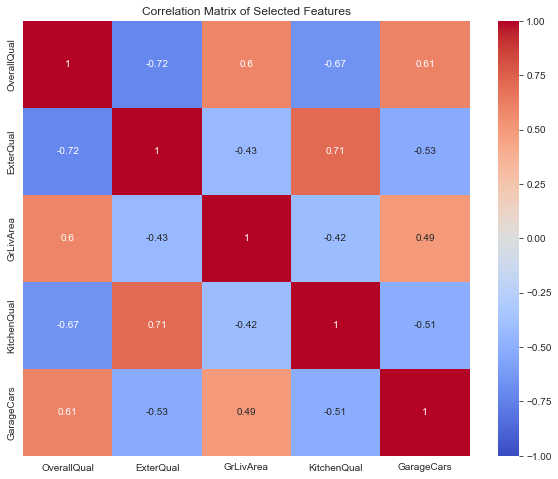

In [97]:
# Calculate the correlation matrix for the selected features
feature_correlation_matrix = filtered_df.corr()

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(feature_correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Selected Features')
plt.show()


#### Remove Highly Correlated Features

Lets remove 'ExterQual' since it is fairly strongly correlated with OverallQual. OverallQual seems more relevant. 

In [98]:
# Remove 'ExteriorQuality' from the features_to_keep list
features_to_keep.remove('ExterQual')

# Create new DataFrame with the updated list of features
updated_filtered_df = df[features_to_keep]

# Show the updated filtered DataFrame
print(updated_filtered_df.head())


ValueError: list.remove(x): x not in list

## Model Fitting

Here both models are trained on the preprocessed training set. 

#### Create Separate objects for Target Variable and Input Features

In [7]:
#Target Variable
y = df.SalePrice

#Input Features
X = updated_filtered_df


#### Train Test Split

In [8]:
# Split X and y into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size=0.2,
                                                   random_state=1234)

In [9]:
#CONFIRM we have correct number of observations in each subset

print( len(X_train), len(X_test), len(y_train), len(y_test))

1160 291 1160 291


#### Standard Scaler
Linear Regression assumes that input features are normally distributed. We need to make sure that input features are on the same scale because the model can get thrown off if there are large differences.  StandardScaler transforms each feature by subtracting the mean and dividing by the STD. Basically, this standardizes the data to a mean of 0 and a STD of 1.

In [10]:
scaler = StandardScaler()

In [11]:
# Standardize X_train and X_test
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### SKLEARN ALGO
Here we fit a model with SKLearn 

In [12]:
sk_model = SKLinearRegression()

# Fit SKLearn Linear Regression on X_train_scaled and y_train and get its duration
start_time_sk = time.time()  # Record start time
sk_model.fit(X_train_scaled, y_train)
end_time_sk = time.time()  # Record end time
sk_duration = end_time_sk - start_time_sk  # Calculate duration


#### Get SKLearn Predictions

In [13]:
# Get predictions for X_test_scaled using SKLearn Linear Regression
sk_preds = sk_model.predict(X_test_scaled)

#### Get SKLearn Scores

In [14]:
# Calculate R-squared and MAE for SKLearn Linear Regression
sk_r2 = sk_model.score(X_test_scaled, y_test)
sk_mae = np.mean(np.abs(sk_preds - y_test))

## From-Scratch Algorithm
Here I fit a model with my From-Scratch Linear Regression class.
Note that I am trying multiple alpha values for my model. 

#### Fit Model

In [87]:
#We need to try many alpha values
alpha_values = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5]

#We also need to store the best scoring model
best_r2 = -np.inf  # Initialize best R-squared score to negative infinity
best_model = None  # Initialize the best model to None


for alpha in alpha_values:
    scratch_model = ScratchLinearRegression(alpha=alpha)
    start_time_scratch = time.time()
    scratch_model.fit(X_train_scaled, y_train)
    end_time_scratch = time.time()
    scratch_duration = end_time_scratch - start_time_scratch

    scratch_preds = scratch_model.predict(X_test_scaled)
    scratch_r2 = r2_score(y_test, scratch_preds)
    scratch_mae = mean_absolute_error(y_test, scratch_preds)

    # Update best R-squared score and model if necessary
    if scratch_r2 > best_r2:
        best_r2 = scratch_r2
        best_model = scratch_model

    print("Alpha: {:.3f}, Scratch Linear Regression - R-squared: {:.3f}, MAE: {:.3f}, Duration: {:.3f} seconds".format(alpha, scratch_r2, scratch_mae, scratch_duration))

    # best_model now contains the model with the best R-squared score

# store best_model as scratch_model
scratch_model = best_model


Alpha: 0.001, Scratch Linear Regression - R-squared: 0.059, MAE: 67591.475, Duration: 2.277 seconds
Alpha: 0.005, Scratch Linear Regression - R-squared: 0.819, MAE: 24944.364, Duration: 2.198 seconds
Alpha: 0.010, Scratch Linear Regression - R-squared: 0.820, MAE: 24995.241, Duration: 2.204 seconds
Alpha: 0.050, Scratch Linear Regression - R-squared: 0.819, MAE: 25006.512, Duration: 2.334 seconds
Alpha: 0.100, Scratch Linear Regression - R-squared: 0.819, MAE: 25006.512, Duration: 2.257 seconds
Alpha: 0.500, Scratch Linear Regression - R-squared: 0.819, MAE: 25006.512, Duration: 2.207 seconds


#### Get Scratch Algo Predictions

In [88]:
# Get predictions for X_test_scaled using Scratch Linear Regression
scratch_preds = scratch_model.predict(X_test_scaled)

#### Get Scratch Algo Scores

In [89]:
# Calculate R-squared and MAE for Scratch Linear Regression
scratch_r2 = r2_score(y_test, scratch_preds)
scratch_mae = mean_absolute_error(y_test, scratch_preds)

## Final Results
These results suprised me! My model technically outperformed SKLearn (although I am sure with more hyperparameter tuning SKLearn's could beat mine :) ) 

### Compare Scores

In [99]:
# Print R-squared, MAE, and duration for both models
print("SKLearn Linear Regression - R-squared: {:.3f}, MAE: {:.3f}, Duration: {:.3f} seconds".format(sk_r2, sk_mae, sk_duration))
print("Scratch Linear Regression - R-squared: {:.3f}, MAE: {:.3f}, Duration: {:.3f} seconds".format(scratch_r2, scratch_mae, scratch_duration))

SKLearn Linear Regression - R-squared: 0.819, MAE: 25006.512, Duration: 0.002 seconds
Scratch Linear Regression - R-squared: 0.820, MAE: 24995.241, Duration: 2.207 seconds


### Scatter Plot of Predictions vs. Actual Values
These scatter plots show the relationship between the actual and predicted values for both my from-scratch model and the sklearn model.


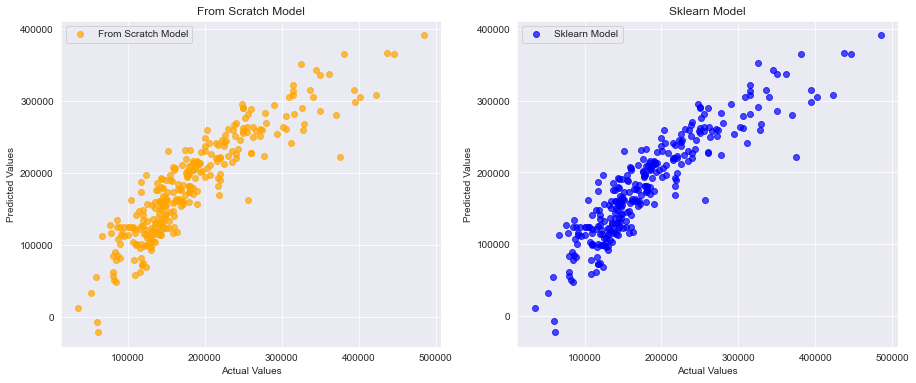

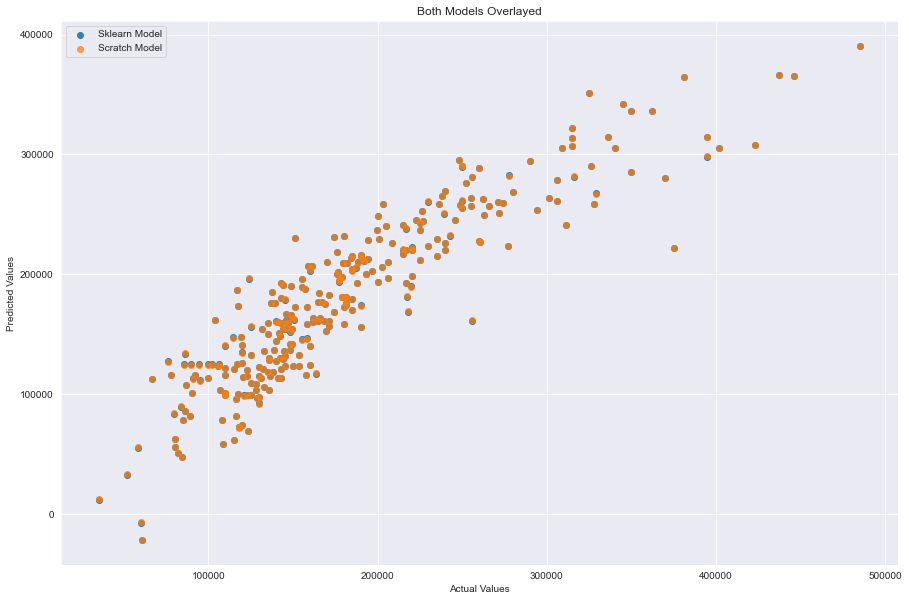

In [92]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

# Scatter plot for Scratch Model
ax1.scatter(y_test, scratch_preds, alpha=0.7, color='orange', label='From Scratch Model')
ax1.set_xlabel('Actual Values')
ax1.set_ylabel('Predicted Values')
ax1.set_title('From Scratch Model')
ax1.legend()

# Scatter plot for Sklearn Model
ax2.scatter(y_test, sk_preds, alpha=0.7, color='blue', label='Sklearn Model')
ax2.set_xlabel('Actual Values')
ax2.set_ylabel('Predicted Values')
ax2.set_title('Sklearn Model')
ax2.legend()

plt.show()


plt.figure(figsize=(15, 10))
plt.scatter(y_test, sk_preds, alpha=0.9, label='Sklearn Model')
plt.scatter(y_test, scratch_preds, alpha=0.7, label='Scratch Model')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Both Models Overlayed')
plt.legend()
plt.show()


### Interpretation:  
**As you can see, the SKLearn model and my From Scratch Model acheived exactly the same results.**
We can see that the predictions from both models are similar. Both models show a strong positive correlation between the predicted and actual values, which means that both models perform pretty well predicting house prices. 

Although the difference is minimal, my **From-Scratch Linear Regression model has a slightly higher R-squared value**, which means it explains a (very) slightly higher proportion of the variance in the dependent variable. 
  
  ---

### R-squared and MAE

**R-squared** is a score that tells us how well our model is doing in predicting the target variable. It's a number between 0 and 1, with 1 being a perfect match and 0 meaning the model isn't helpful at all. So, the closer to 1 our R-squared value is, the better our model is at making predictions.

**Mean Absolute Error (MAE)** is a way to measure how far off our predictions are from the actual values. We just look at the difference between each prediction and the actual value, and then take the average of all those differences. A lower MAE means our model is doing a better job because the predictions are closer to the real values.



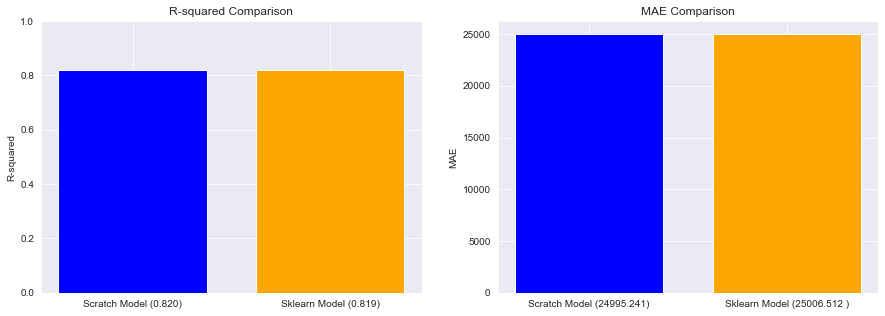

In [96]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

# Bar plot for R-squared comparison
labels = ['Scratch Model (0.820)', 'Sklearn Model (0.819)']
r2_scores = [scratch_r2, sk_r2]
x_r2 = np.arange(len(labels))
width = 0.75

ax1.bar(x_r2, r2_scores, width, color=['blue', 'orange'])
ax1.set_xticks(x_r2)
ax1.set_xticklabels(labels)
ax1.set_ylabel('R-squared')
ax1.set_title('R-squared Comparison')
ax1.set_ylim([0, 1])

# Bar plot for MAE comparison
mae_scores = [scratch_mae, sk_mae]
x_mae = np.arange(len(labels))

ax2.bar(x_mae, mae_scores, width, color=['blue', 'orange'])
ax2.set_xticks(x_mae)
ax2.set_xticklabels(['Scratch Model (24995.241)', 'Sklearn Model (25006.512 )'])
ax2.set_ylabel('MAE')
ax2.set_title('MAE Comparison')

plt.show()


**Interpretation:**
The bar graphs display the R-squared and MAE scores for both the SKLearn Linear Regression and Scratch Linear Regression models.   

The R-squared scores are very similar, but the **From-Scratch model has a marginally higher score**, meaning it explains a slightly higher proportion of the variance in the house prices. 
  
The MAE scores show that the **From-Scratch model has a slightly lower error**, meaning it makes smaller prediction errors on average compared to the SKLearn model. However, it's important to note that the differences in both R-squared and MAE scores are minimal, indicating that both models have comparable performance.


### Results of Hyperparameter Tuning (Alpha Values)
Comparing the worst and best alpha values, we can see that the difference in R-squared is enormous! The best alpha value also resulted in a much lower MAE. This demonstrates (to me) the importance of hyperparameter tuning in improving the performance of the model.


#### Graphing the Worst and Best Alpha Values Results
These scatter plots compare the predictions made by the from-scratch model using the worst and best alpha values. The worst alpha value results in predictions that deviate more from the actual values, while the best alpha value leads to much better predictions, as shown by the tighter clustering around the diagonal line.")


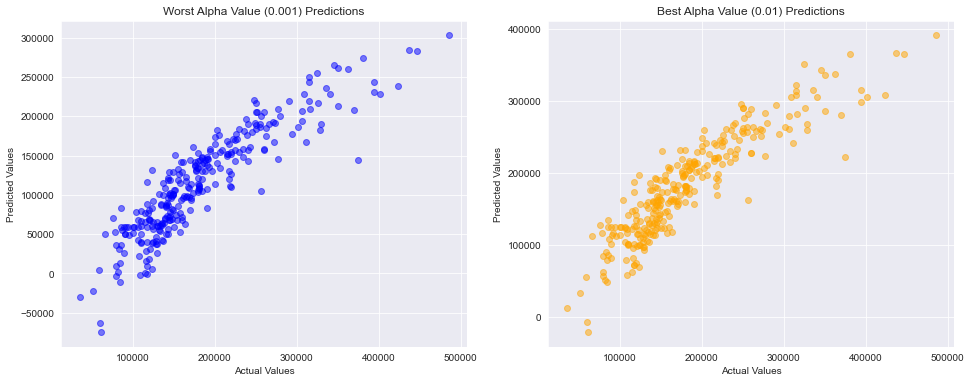

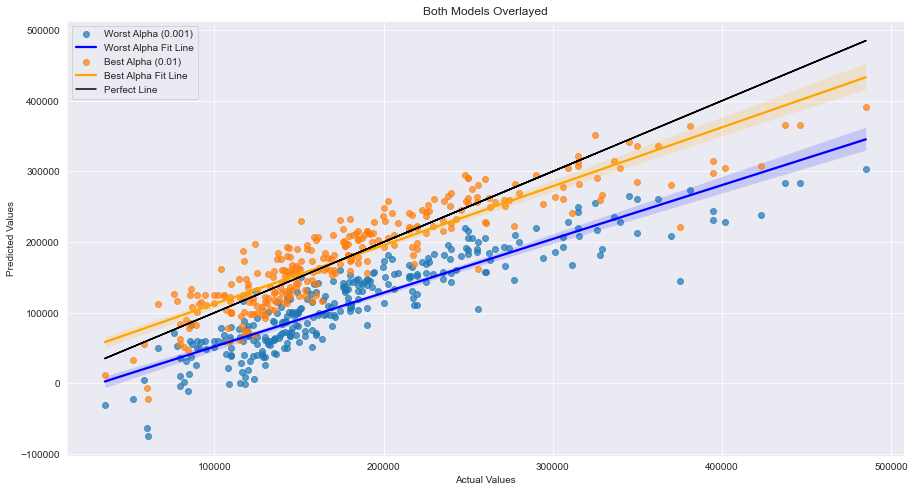

In [82]:
# Recompute predictions for the worst and best alpha values
scratch_model_worst = ScratchLinearRegression(alpha=worst_alpha)
scratch_model_worst.fit(X_train_scaled, y_train)
scratch_preds_worst = scratch_model_worst.predict(X_test_scaled)

scratch_model_best = ScratchLinearRegression(alpha=best_alpha)
scratch_model_best.fit(X_train_scaled, y_train)
scratch_preds_best = scratch_model_best.predict(X_test_scaled)

# Create subplots comparing predictions for the worst and best alpha values
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

ax1.scatter(y_test, scratch_preds_worst, alpha=0.5, color='blue')
ax1.set_xlabel('Actual Values')
ax1.set_ylabel('Predicted Values')
ax1.set_title(f'Worst Alpha Value ({worst_alpha}) Predictions')

ax2.scatter(y_test, scratch_preds_best, alpha=0.5, color='orange')
ax2.set_xlabel('Actual Values')
ax2.set_ylabel('Predicted Values')
ax2.set_title(f'Best Alpha Value ({best_alpha}) Predictions')
plt.show()


plt.figure(figsize=(15, 8))

# Scatter plot for worst and best alpha predictions with regression lines
sns.regplot(x=y_test, y=scratch_preds_worst, scatter_kws={'alpha': 0.7}, line_kws={'color': 'blue', 'label': 'Worst Alpha Fit Line'}, label='Worst Alpha (0.001)')
sns.regplot(x=y_test, y=scratch_preds_best, scatter_kws={'alpha': 0.7}, line_kws={'color': 'orange', 'label': 'Best Alpha Fit Line'}, label='Best Alpha (0.01)')

# Perfect line
plt.plot(y_test, y_test, color='black', label='Perfect Line')

plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Both Models Overlayed')
plt.legend()
plt.show()


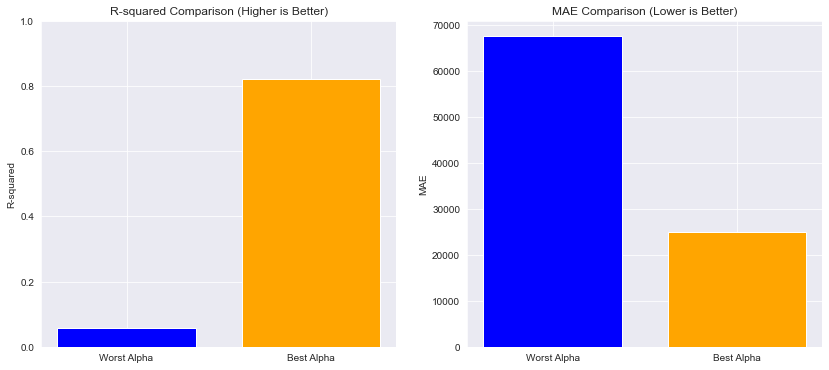

In [59]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

# Bar plot for R-squared comparison
labels = ['Worst Alpha', 'Best Alpha']
r2_scores = [worst_r2, best_r2]
x_r2 = np.arange(len(labels))
width = 0.75 

ax1.bar(x_r2, r2_scores, width, color=['blue', 'orange']) 
ax1.set_xticks(x_r2)
ax1.set_xticklabels(labels)
ax1.set_ylabel('R-squared')
ax1.set_title('R-squared Comparison (Higher is Better)')
ax1.set_ylim([0, 1])

# Bar plot for MAE comparison
mae_scores = [worst_mae, best_mae]
x_mae = np.arange(len(labels))

ax2.bar(x_mae, mae_scores, width, color=['blue', 'orange'])  
ax2.set_xticks(x_mae)
ax2.set_xticklabels(labels)
ax2.set_ylabel('MAE')
ax2.set_title('MAE Comparison (Lower is Better)')

plt.show()


## Conclusion

**Overall:**   
- My purpose here was to test-drive my Linear Regression algorithm.  I thuoght a good way to try it out was to evaluate my model's performance by comparing it with SKLearn's Linear Regression.  
  
- As expected, my model was much slower than SKLearn's, mainly because I avoided using libraries like NumPy for vectorization. However, despite the slower speed, the performance of my model was surprisingly close to that of SKLearn's when it came to accuracy. This demonstrates that the fundamentals of my custom algorithm are solid!  
  
**Takeaways:**  
- One significant takeaway from this project is the importance of hyperparameter tuning. When I initially fit my model with the default alpha value of 0.001, the performance was terrible (this is displayed above). However, after exploring different alpha values and optimizing the model, I managed to achieve a slightly better score than SKLearn's (at default values)! This was an exciting and encouraging result.

- This project also highlighted some potential areas of improvement for my model. For example, incorporating NumPy for vectorization would make it more efficient. Additionally, I'm interested in experimenting with adding regularization options to my algorithm to further my understanding of linear regression techniques.

This project was an excellent learning experience! I now have a much stronger grasp of the inner workings of Linear Regression and the importance of fine-tuning model parameters.